In [72]:
# Audio Alert

from IPython.display import display, Javascript

def play_beep(frequency=440, duration=1000, volume=0.5):
    js_code = f"""
    (function() {{
        var context = new (window.AudioContext || window.webkitAudioContext)();
        var oscillator = context.createOscillator();
        var gainNode = context.createGain();
        
        oscillator.type = 'sine';
        oscillator.frequency.value = {frequency};
        oscillator.connect(gainNode);
        gainNode.connect(context.destination);
        
        gainNode.gain.setValueAtTime({volume}, context.currentTime);
        
        oscillator.start();
        oscillator.stop(context.currentTime + {duration/1000});
    }})();
    """
    display(Javascript(js_code))

In [10]:
import matplotlib.pyplot as plt
import numpy as np

loss_baseline = {
    "124M": 3.424958,
    "350M": 3.083089,
    "774M": 3.000580,
    "1558M": 2.831273,
}
hella2_baseline = { # for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}
hella3_baseline = { # for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}

def parse_logfile(logfile):
    streams = {}
    with open(logfile, "r") as f:
        for line in f:
            parts = line.split()
            step = int(parts[0].split(":")[1])
            for part in parts[1:]:
                stream, val = part.split(":")
                val = float(val)
                if stream not in streams:
                    streams[stream] = {}
                streams[stream][step] = val
    streams_xy = {}
    for k, v in streams.items():
        xy = sorted(list(v.items()))
        streams_xy[k] = list(zip(*xy))
    return streams_xy

def plot_logs(files, sz=None, max_steps=None, max_loss=None, max_norm=None):
    xlim = {"left": -10, "right": max_steps} if max_steps else None
    trl_ylim = {"top": max_loss} if max_loss else None
    norm_ylim = {"top": max_norm} if max_norm else None
    alpha = 0.5 if len(files) > 1 else 1.0
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    
    for f, name in files:
        data = parse_logfile(f)
        
        # 1. trl + tel
        ax = axs[0, 0]
        if 'trl' in data:
            ax.plot(data['trl'][0], data['trl'][1], label=f"{name} train loss", alpha=alpha)
            print(f"{name} min train loss: ", min(data["trl"][1]))
        if 'tel' in data:
            ax.plot(data['tel'][0], data['tel'][1], label=f"{name} val loss", alpha=alpha)
            print(f"{name} min val loss: ", min(data["tel"][1]))
        ax.set_title('Training and Validation Loss')
        ax.set_xlabel('Step')
        ax.set_yscale('log')
        ax.grid(True, linestyle='--', color='gray', alpha=0.3)
        if xlim: ax.set_xlim(**xlim)
        ax.autoscale(enable=True, axis='y', tight=False)
        if trl_ylim: ax.set_ylim(**trl_ylim)
        ax.legend(fontsize=6)

        # 2. eval
        ax = axs[0, 1]
        if 'eval' in data:
            ax.plot(data['eval'][0], data['eval'][1], label=name)
            print(f"{name} max HellaSwag: ", max(data["eval"][1]))
        ax.set_title('HellaSwag')
        ax.set_xlabel('Step')
        ax.grid(True, linestyle='--', color='gray', alpha=0.3)
        if xlim: ax.set_xlim(**xlim)
        ax.legend(fontsize=6)

        # 3. lr
        ax = axs[1, 0]
        if 'lr' in data:
            ax.plot(data['lr'][0], data['lr'][1], label=name)
        ax.set_title('Learning Rate')
        ax.set_xlabel('Step')
        ax.set_yscale('log')
        ax.grid(True, linestyle='--', color='gray', alpha=0.3)
        if xlim: ax.set_xlim(**xlim)
        ax.legend(fontsize=6)

        # 4. norm
        ax = axs[1, 1]
        if 'norm' in data:
            ax.plot(data['norm'][0], data['norm'][1], label=name, alpha=alpha)
        ax.set_title('Gradient Norm')
        ax.set_xlabel('Step')
        ax.set_yscale('log')
        ax.grid(True, linestyle='--', color='gray', alpha=0.3)
        if xlim: ax.set_xlim(**xlim)
        ax.autoscale(enable=True, axis='y', tight=False)
        if norm_ylim: ax.set_ylim(**norm_ylim)
        ax.legend(fontsize=6)
    
    # benchmarks for sz
    if sz and sz in loss_baseline.keys():
        ax = axs[0, 0]
        ax.axhline(loss_baseline[sz], color='r', linestyle='--', linewidth=1, label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
        ax.legend(fontsize=6)
        ax = axs[0, 1]
        ax.axhline(hella2_baseline[sz], color='r', linestyle='--', linewidth=1, label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
        ax.axhline(hella3_baseline[sz], color='g', linestyle='--', linewidth=1, label=f"OpenAI GPT-3 ({sz}) checkpoint val loss")
        ax.legend(fontsize=6)
        
    plt.tight_layout()
    plt.show()

llm.c fwedu gpt3 125M min train loss:  2.8702
llm.c fwedu gpt3 125M min val loss:  3.0363
llm.c fwedu gpt3 125M max HellaSwag:  0.3052
llm.c fwedu-hermes gpt2 350M min train loss:  2.6096
llm.c fwedu-hermes gpt2 350M min val loss:  2.8659
llm.c fwedu-hermes gpt2 350M max HellaSwag:  0.3435
llm.c fwedu-hermes gpt3 125M min train loss:  2.917
llm.c fwedu-hermes gpt3 125M min val loss:  3.4773
llm.c fwedu-hermes gpt3 125M max HellaSwag:  0.2665


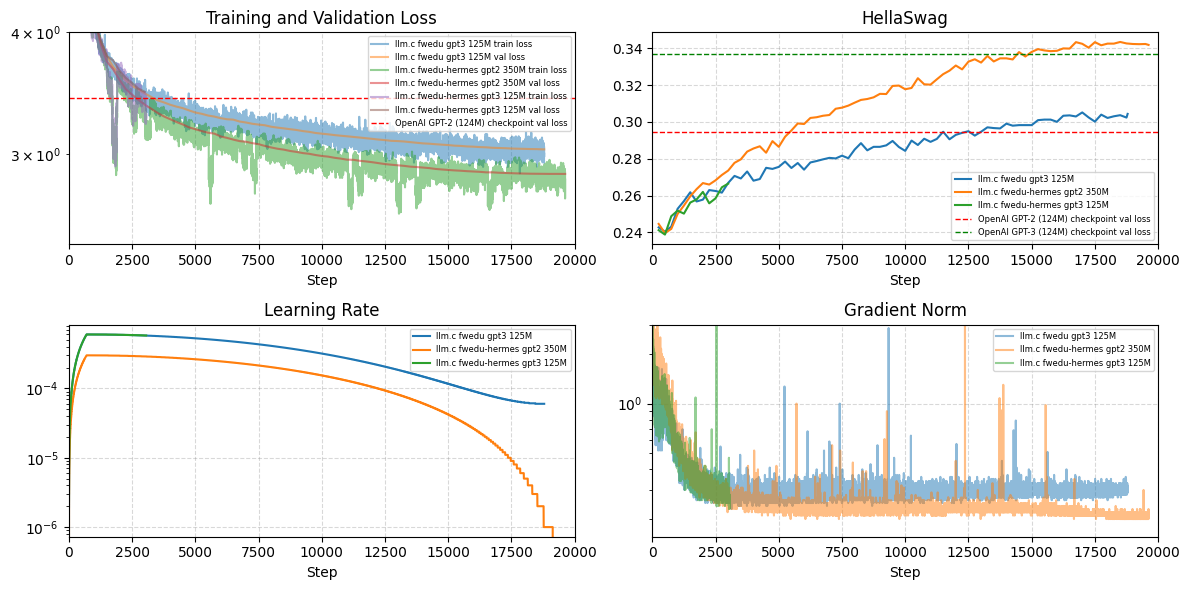

In [84]:
runs = [
    ("../log_gpt3_125M_edu_v5/main.log", "llm.c fwedu gpt3 125M"),
    ("../log_gpt3_125M_edu_hermes_v5/old.log", "llm.c fwedu-hermes gpt2 350M"),
    ("../log_gpt3_125M_edu_hermes_v5/main.log", "llm.c fwedu-hermes gpt3 125M"),
]
plot_logs(runs, sz="124M", max_steps=20_000, max_loss=4, max_norm=3.0)

In [ ]:
from time import sleep

while True:
    last_gn = parse_logfile(runs[-1][0])["norm"][1][-1]
    if last_gn > 2:
        play_beep(frequency=440, duration=400, volume=0.1)
        sleep(0.5)
        play_beep(frequency=440, duration=400, volume=0.1)
        print(last_gn)
    elif last_gn > 1:
        play_beep(frequency=220, duration=300, volume=0.1)
        sleep(0.5)
        play_beep(frequency=220, duration=300, volume=0.1)
        print(last_gn)
    sleep(2)